# Network Architecture Exploration: Understanding Underfitting and Overfitting
## Background
This exercise aims to demonstrate how different neural network architectures can lead to underfitting or overfitting. You will experiment with various configurations of a fully connected neural network to observe these phenomena.

## Underfitting
Occurs when a model is too simple to capture the underlying pattern of the data. Often caused by having too few layers or neurons.

## Overfitting
Happens when a model learns the training data too well, including the noise, making it perform poorly on new, unseen data. This can result from having too many layers or neurons.

## Setup
Import the necessary libraries and prepare the dataset.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles

from utils import make_dataset, plot_training_history

## Data

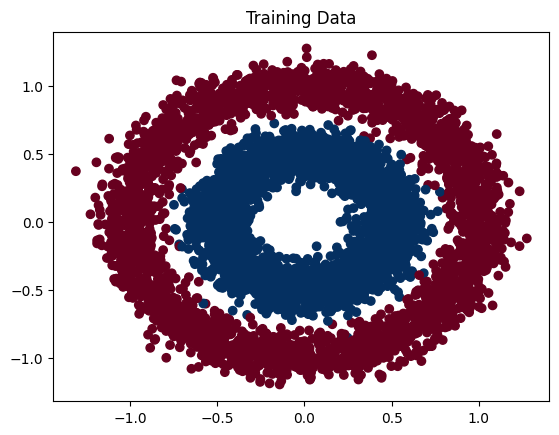

In [2]:
# Generate synthetic data
X, y = make_circles(n_samples=6000, noise=0.09, factor=0.5, random_state=42)

# Visualize the dataset
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)
plt.title("Training Data")
plt.show()


In [3]:
# Splitting the dataset into training, validation and test sets
dataset = make_dataset(X, y)
dataset_trainval, dataset_test = train_test_split(dataset, test_size=0.5, random_state=42)
dataset_train, dataset_val = train_test_split(dataset_trainval, test_size=0.2, random_state=42)

# define DataLoaders
train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset_val, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset_test, batch_size=64, shuffle=False, num_workers=4)

# Model Building
Create a model with a variable number of layers and neurons.

In [4]:
class MyModel(nn.Module):
    def __init__(self, num_layers, num_neurons, activation_function):
        super().__init__()
        # input and 1st hidden layers
        self.hidden1 = nn.Linear(2, num_neurons)
        # additional hidden layers
        for _ in range(num_layers - 1):
            self.hidden = nn.Linear(num_neurons, num_neurons)
        # output layers
        self.output = nn.Linear(num_neurons, 1)
        # activation functions
        self.act_hidden = activation_function
        self.act_output = nn.Sigmoid()

    def forward(self, x, num_layers):
        x = self.act_hidden(self.hidden1(x))
        for _ in range(num_layers - 1):
            x = self.act_hidden(self.hidden(x))
        x = self.act_output(self.output(x))
        return x

## Helper functions

In [5]:
# train loop to be run for training with train_loader and several epochs
def train_loop(dataloader, model, loss_fn, optimizer, num_layers):
    model.train()
    num_samples = len(dataloader.dataset)
    running_train_loss, correct_predictions = 0.0, 0
    
    for batch, (batch_X, batch_y) in enumerate(dataloader):
        y_pred = model.forward(batch_X, num_layers) # fit model; y_pred has shape [batchsize, 1]
        train_loss = loss_fn(y_pred, batch_y.unsqueeze(1)) # calculate loss; unsqueeze(1): shape [batchsize, ] -> shape [batchsize, 1]
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
        running_train_loss += train_loss.item() * len(batch_X)
        correct_predictions += torch.sum(y_pred.round() == batch_y.unsqueeze(1)).item() # for 2 classes
    
    epoch_train_loss = running_train_loss / num_samples
    epoch_train_accuracy = correct_predictions / num_samples

    return epoch_train_loss, epoch_train_accuracy


# eval_loop to be run for validation with val_loader and several epochs
# eval_loop to be run for test with test_loader and not in epoch loop
def eval_loop(dataloader, model, loss_fn, num_layers):
    model.eval()
    num_samples = len(dataloader.dataset)
    running_loss, correct_predictions = 0.0, 0

    with torch.no_grad():
        for batch_X, batch_y in dataloader:
            y_pred = model.forward(batch_X, num_layers)
            loss = loss_fn(y_pred, batch_y.unsqueeze(1))

            running_loss += loss.item() * len(batch_X)
            correct_predictions += torch.sum(y_pred.round() == batch_y.unsqueeze(1)).item()

    epoch_loss = running_loss / num_samples
    epoch_accuracy = correct_predictions / num_samples

    return epoch_loss, epoch_accuracy

## Train and evaluate model

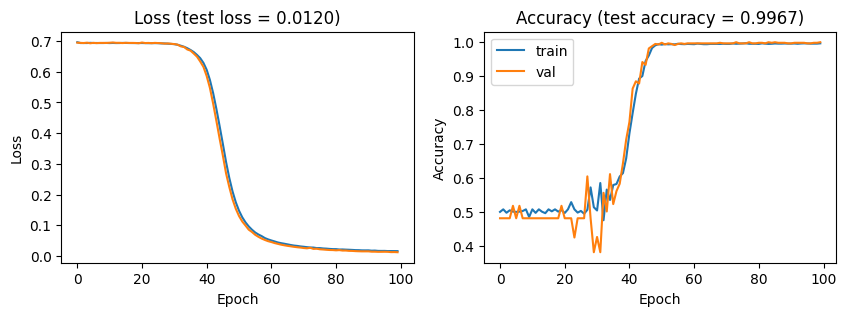

In [8]:
num_layers = 3
num_neurons = 30
activation_function = nn.Sigmoid()
model= MyModel(num_layers=num_layers, num_neurons=num_neurons, activation_function=activation_function)
loss_fn = nn.BCELoss() # binary crossentropy
optimizer = Adam(model.parameters())
epochs = 100

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training and validation loop
for epoch in range(epochs):
      train_loss, train_accuracy = train_loop(dataloader=train_loader, model=model, loss_fn=loss_fn, optimizer=optimizer, num_layers=num_layers)
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)
 
      val_loss, val_accuracy = eval_loop(dataloader=val_loader, model=model, loss_fn=loss_fn, num_layers=num_layers)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)

# Test loop
test_loss, test_accuracy = eval_loop(dataloader=test_loader, model=model, loss_fn=loss_fn, num_layers=num_layers) 

# visualize data
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies, test_accuracy, test_loss)

## Early stopping

In [ ]:
# Early stopping in pytorch: https://pytorch.org/ignite/generated/ignite.handlers.early_stopping.EarlyStopping.html

# Implementation in TensorFlow
TensorFlow provides an easy way to implement early stopping through callbacks. Here’s how you can add early stopping to your training process:

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Create an EarlyStopping callback instance
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Include this callback in the model's fit method
model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping])
